# DATA 512 Homework 1: Professionalism & Reproducibility

## Wikipedia Articles Traffic Analysis (Jul 2015 - Sep 2024)

### Project Overview

The goal of this project is to construct, analyze, and publish a dataset of monthly article traffic from the english Wikipedia for a predefined list of rare disease articles. The timeframe for data collection is from **July 1, 2015**, through **September 30, 2024**. This data will be used to generate three distinct time series datasets that record desktop, mobile, and cumulative (desktop + mobile) pageviews for each article. The main objective is to ensure reproducibility in data collection and analysis while following best practices for open scientific research, allowing for transparency and validation.

### License

#### Code Attribution

Snippets of the code used for fetching data through wikipedia API, were taken from a code example developed by **Dr. David W. McDonald** for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the **Creative Commons CC-BY license**.

In order to measure article traffic from 2015-2024, we will need to collect data from the Wikimedia Analytics API. The Pageviews API call (documentation) provides access to desktop, mobile web, and mobile app traffic data starting from July 2015 through the previous complete month. We will need to collect data for articles on rare diseases, the predefined list of articles provided in a csv file, which will be using in the later section of the code.

In the below section, importing the libraries that are necessary to work with API calls, parse data and save data into json file.

In [25]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

The data acquisition code relies on some constants that help make the code a bit more readable and flexible. These include request headers, API parameters, name and format of the files to be generated later.  Th goal is to save 3 different files for desktop , mobile and cumulative (desktop +mobile) along with start and end date. For example rare-disease_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json. 

In [26]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<manasars@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this will be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be dynamically set during the calls
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set as per the analysis needs
    "end":         "2024093000"    
}

# Template for mobile views through mobile web.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {**ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, "access": "mobile-web"}

# Template for mobile views through mobile app.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {**ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, "access": "mobile-app"}


# Input file path containing article titles.
ARTICLE_LIST_FILE = "InputFiles/rare-disease_cleaned.AUG.2024.csv"

# Output file names and format
START_DATE = "201507"
END_DATE = "202409"
MOBILE_FILE = f'generated_datafiles/rare-disease_monthly_desktop_{START_DATE}-{END_DATE}.json'
DESKTOP_FILE = f'generated_datafiles/rare-disease_monthly_mobile_{START_DATE}-{END_DATE}.json'
CUMULATIVE_FILE = f'generated_datafiles/rare-disease_monthly_cumulative_{START_DATE}-{END_DATE}.json'


csv library will be used to read article list from csv and store it in a variable for later use.

In [27]:
import csv

This custom module will read the csv file from the path passed as argument, and store the article list in the temporary list variable to be used during API calls.The csv reader object treats each row as a dictionary, so we iterate over each row and access the value for key "disease" which is the article name and append to article list variable.

In [48]:
# Function to read rare disease article titles from the CSV file
def read_article_file(file_path):
    """
    Read the article titles from a CSV file.

    Args:
    - file_path (str): Path to the CSV file containing article titles.

    Returns:
    - list: A list of article titles extracted from the 'disease' column of the CSV file.

    """
    article_titles = []
    try:
        with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if 'disease' in row:
                    article_titles.append(row['disease']) 
    except FileNotFoundError:
        print(f"Error: CSV file '{file_path}' not found. Please check the file path and try again.")
        raise
    except Exception as e:
        print(f"Unexpected error while reading '{file_path}': {e}")
        raise
    return article_titles


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. 

In [29]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


The code section below defines a custom module that is used to process the data from APIs and store in the form of JSOn file. The goal is to produce three different files as follows:

1. Monthly mobile access - The API separates mobile access types into two separate requests, we will sum these to make one count for all mobile pageviews and store the mobile access data in a file called:
rare-disease_monthly_mobile_`<startYYYYMM-<endYYYYMM>`.json

2. Monthly desktop access - Monthly desktop page traffic is based on one single request. we will store the desktop access data in a file called:
rare-disease_monthly_desktop_`<startYYYYMM>-<endYYYYMM>`.json

3. Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. we will store the monthly cumulative data in a file called:
rare-disease_monthly_cumulative_`<startYYYYMM>-<endYYYYMM>`.json as already defined in constants.


The data returned from APIs is saved in the dictionary, then is processed to meet the above said file format needss, by iterating through each item in the doctionary. 

Before saving the data, we will discard the attribute "access" type to avoid any confusion and then save the data in a JSON file.


In [30]:
# Function to process and save data for all access types (mobile, desktop, cumulative)
def process_and_save_data(articles):
    """
    Fetches and processes pageviews data for a list of Wikipedia articles, combining desktop and mobile access types, 
    and saves the processed data to 3 separate JSON files.

    ### Parameters:
    - `articles` (list of str): A list of Wikipedia article titles to process.

    ### Returns:
    None

    ### Output Files:
    - `MOBILE_FILE`: JSON file containing the processed monthly views for mobile access.
    - `DESKTOP_FILE`: JSON file containing the processed monthly views for desktop access.
    - `CUMULATIVE_FILE`: JSON file containing the cumulative views for each article, combining desktop and mobile.

    """

    mobile_data = {}
    desktop_data = {}
    cumulative_data = {}

    for article in articles:
        print(f"Processing data for article: {article}")
        try:
            # Fetch data for each access type - desktop, mobile-web, mobile-app and store as dictionary
            desktop_views = request_pageviews_per_article(article)
            mobile_web_views = request_pageviews_per_article(article.replace(' ', '_'), request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
            mobile_app_views = request_pageviews_per_article(article.replace(' ', '_'), request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)

            # Combine mobile-web and mobile-app for total mobile views
            mobile_combined = {}
            for item in mobile_web_views.get('items', []):
                month = item['timestamp'][:6]
                if month not in mobile_combined:
                    mobile_combined[month] = {**item} 
                    mobile_combined[month]["views"] = item['views'] 
                else:
                    # Sum views for the same month
                    mobile_combined[month]["views"] += item['views']  

            for item in mobile_app_views.get('items', []):
                month = item['timestamp'][:6]
                if month not in mobile_combined:
                    mobile_combined[month] = {**item} 
                    mobile_combined[month]["views"] = item['views'] 
                else:
                    # Sum views for the same month
                    mobile_combined[month]["views"] += item['views']  

            # Create cumulative data by combining desktop and mobile data.
            cumulative_views = {}
            for item in desktop_views.get('items', []):
                month = item['timestamp'][:6]
                # Initialize with full item attributes, removing access, and add mobile views
                cumulative_views[month] = {**item}  # Keep all attributes
                cumulative_views[month]["views"] = item['views'] + mobile_combined.get(month, {}).get("views", 0)

            # Store the desktop and mobile data for each article, retaining all attributes except access
            mobile_data[article] = [{k: v for k, v in month_data.items() if k != 'access'} for month, month_data in mobile_combined.items()]
            desktop_data[article] = [{k: v for k, v in item.items() if k != 'access'} for item in desktop_views.get('items', [])]
            cumulative_data[article] = [{k: v for k, v in month_data.items() if k != 'access'} for month, month_data in cumulative_views.items()]

        except Exception as e:
            print(f"Error processing data for {article}: {e}")

    # Save the results to JSON files - Desktop, Mobile and Cumulative
    try:
        with open(MOBILE_FILE, 'w', encoding='utf-8') as mobile_file:
            json.dump(mobile_data, mobile_file, indent=4)
            print(f"Saved mobile data to {MOBILE_FILE}")

        with open(DESKTOP_FILE, 'w', encoding='utf-8') as desktop_file:
            json.dump(desktop_data, desktop_file, indent=4)
            print(f"Saved desktop data to {DESKTOP_FILE}")

        with open(CUMULATIVE_FILE, 'w', encoding='utf-8') as cumulative_file:
            json.dump(cumulative_data, cumulative_file, indent=4)
            print(f"Saved cumulative data to {CUMULATIVE_FILE}")
    except Exception as e:
        print(f"Error writing JSON files: {e}")

We will now use our custom modules to read the csv and store the article list in temporary variable and use it to read and process the data using the above defined custom module.

In [31]:

# Read the article titles from the CSV
article_titles = read_article_file(ARTICLE_LIST_FILE)

# Process and save data for all articles
process_and_save_data(article_titles)

Processing data for article: Klinefelter syndrome
Processing data for article: Aarskog–Scott syndrome
Processing data for article: Abetalipoproteinemia
Processing data for article: MT-TP
Processing data for article: Ablepharon macrostomia syndrome
Processing data for article: Acanthocheilonemiasis
Processing data for article: Acanthosis nigricans
Processing data for article: Aceruloplasminemia
Processing data for article: Megaesophagus
Processing data for article: Achard–Thiers syndrome
Processing data for article: Achondrogenesis
Processing data for article: Achondroplasia
Processing data for article: Dwarfism
Processing data for article: Osteochondrodysplasia
Processing data for article: Fibroblast growth factor receptor 3
Processing data for article: Vestibular schwannoma
Processing data for article: Brain tumor
Processing data for article: Acquired generalized lipodystrophy
Processing data for article: Barraquer–Simons syndrome
Processing data for article: Acrodermatitis enteropath

We will load the package required for basic data analysis and visualisation in python.

In [32]:

import pandas as pd
import matplotlib.pyplot as plt

To begin the analysis, we will have to first read the JSON files that were previously generated and load them into dataframes to be able to analyse and visualize. since the JSON files have nested structures, we will first load it as a dictionary and then convert it into dataframe. We will open and read the JSON files in read mode to accidentally avoid any updates to the original file. For analysis we need only views and timestamps for each article, so we will focus on these columns.  We have to ensure the views is set to numeric data type so that we can apply all mathematical operations on this column during our analysis without facing any issues. Similarly we will convert timestamp from string to datetime format for easy analysis.

In [37]:
# Read the JSON files.
with open(MOBILE_FILE, 'r', encoding='utf-8') as mobile_file:
        mobile_data = json.load(mobile_file)

with open(DESKTOP_FILE, 'r', encoding='utf-8') as desktop_file:
        desktop_data = json.load(desktop_file)

# convert the loaded JSON data into pandas DataFrames
desktop_df = pd.DataFrame.from_dict({k: pd.Series({d['timestamp']: d['views'] for d in v}) for k, v in desktop_data.items()})
mobile_df = pd.DataFrame.from_dict({k: pd.Series({d['timestamp']: d['views'] for d in v}) for k, v in mobile_data.items()})

# Ensuring numeric data types for views column
desktop_df = desktop_df.apply(pd.to_numeric, errors='coerce')
mobile_df = mobile_df.apply(pd.to_numeric, errors='coerce')

# Convert index to datetime for desktop and mobile data
desktop_df.index = pd.to_datetime(desktop_df.index.str[:6], format='%Y%m')
mobile_df.index = pd.to_datetime(mobile_df.index.str[:6], format='%Y%m')

    

For our first analysis, we are interested in showing time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. So the first step is to calculate average views of every article in both desktop and mobile dataframe. Then pick the articles with highest and lowest calculated averages from both dataframe and plot them in a single plot.

Adding custom lables to legends help identify mobile and desktop articles separately. Also having distinguished line patterns for desktop and mobile makes the plot visually appealing and easy to understand. For every plot that follows later, I am saving them into png once rendered, for later use.

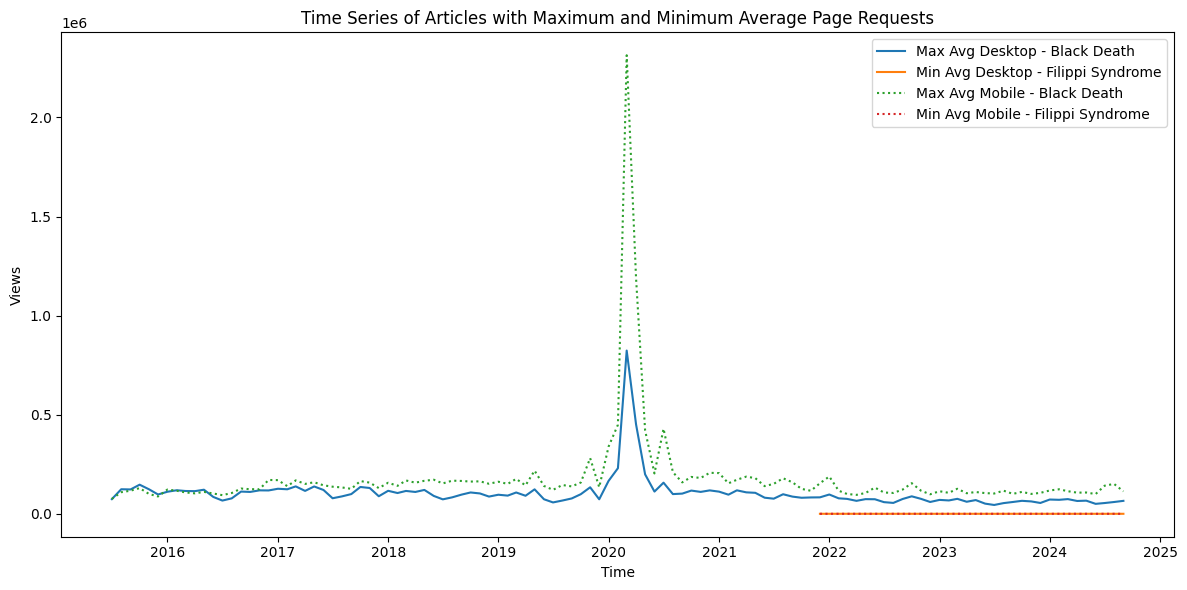

In [50]:
# Maximum average and Minimum average articles

# Calculate average views for each article
desktop_avg = desktop_df.mean(axis=0)
mobile_avg = mobile_df.mean(axis=0)

# Choosing artciles with the Maximum and Minimum Average
max_desktop_article = desktop_avg.idxmax()
min_desktop_article = desktop_avg.idxmin()
max_mobile_article = mobile_avg.idxmax()
min_mobile_article = mobile_avg.idxmin()

# Format the plot
plt.figure(figsize=(12, 6))
plt.plot(desktop_df[max_desktop_article], label=f'Max Avg Desktop - {max_desktop_article}', linestyle='-')
plt.plot(desktop_df[min_desktop_article], label=f'Min Avg Desktop - {min_desktop_article}', linestyle='-')
plt.plot(mobile_df[max_mobile_article], label=f'Max Avg Mobile - {max_mobile_article}', linestyle=':')
plt.plot(mobile_df[min_mobile_article], label=f'Min Avg Mobile - {min_mobile_article}', linestyle=':')
plt.title('Time Series of Articles with Maximum and Minimum Average Page Requests')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.savefig('generated_plots/max_avg_min_avg_page_requests.png')
plt.show()
plt.close()

In the graph, solid lines represent the trend in views from Jul 2015 - Sep 2024 for articles with max and min average views on desktop and dotted lines represent the trend in views from Jul 2015 - Sep 2024 for with max and min average views on mobile. One can notice that "Black Death" has maximum average both on mobile and desktop with views close to 3 million around 2020, when we had pandemic. "Filippi Syndrome" has the lowest average views on both mobile and desktop.

For the next analysis, we are interested in the top 10 article pages by largest (peak) page views over the entire timeframe. First step is to calculate maximum views for each article and then extract top 10 of them. Since in the dataframe each column represents one article, we can compute max value for each column and extract top 10. 


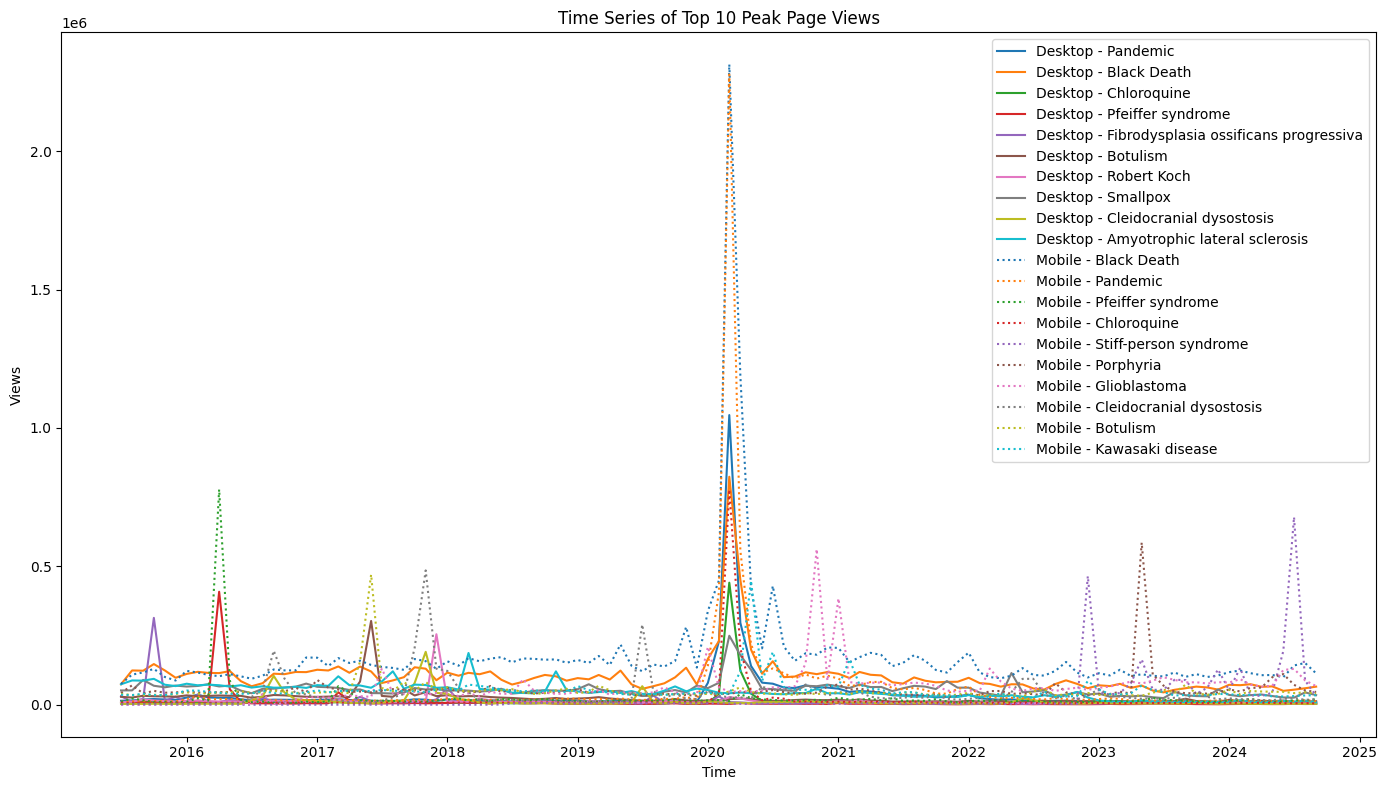

In [38]:
# Top 10 Peak Page Views

# calculates the maximum value for each column in desktop_df along the row axis 
# and extracts the 10 articles with the largest peak values 
peak_desktop = desktop_df.max(axis=0).nlargest(10)
peak_mobile = mobile_df.max(axis=0).nlargest(10)

plt.figure(figsize=(14,8))

# Plot the data points from the desktop dataframe
for article in peak_desktop.index:
    plt.plot(desktop_df[article], label=f'Desktop - {article}', linestyle='-')

# Plot the data points from the mobile dataframe
for article in peak_mobile.index:
    plt.plot(mobile_df[article], label=f'Mobile - {article}', linestyle=':')

# Format the plot
plt.title('Time Series of Top 10 Peak Page Views')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('generated_plots/top_10_peak_page_views.png')
plt.show()
plt.close()


In the graph, solid lines represent the trend in views from Jul 2015 - Sep 2024 for top 10 articles  with highest views on desktop and dotted lines represent the trend in views from Jul 2015 - Sep 2024 for top 10 articles  with highest views on mobile. As seen in the graph, most articles with highest peaks are on mobile. Amongst them "Pandemic" and "Balck Death" articles has the highest views close to 3 million, especailly around the time COVID-19 hit the world. Since "Black Death" was also a pandemic, this might have had lot of views during COVID-19 pandemic time.

In our last analysis, we are interested in the time series of the articles that have fewest months of data available. One of the ways to do it is to count the number of non value records (represnted by months) for each column (represented by article) and then extract the 10 articles with smallest value. 


For this graph alone, I am rendering the legends outside the plot to avoid the overlap. 

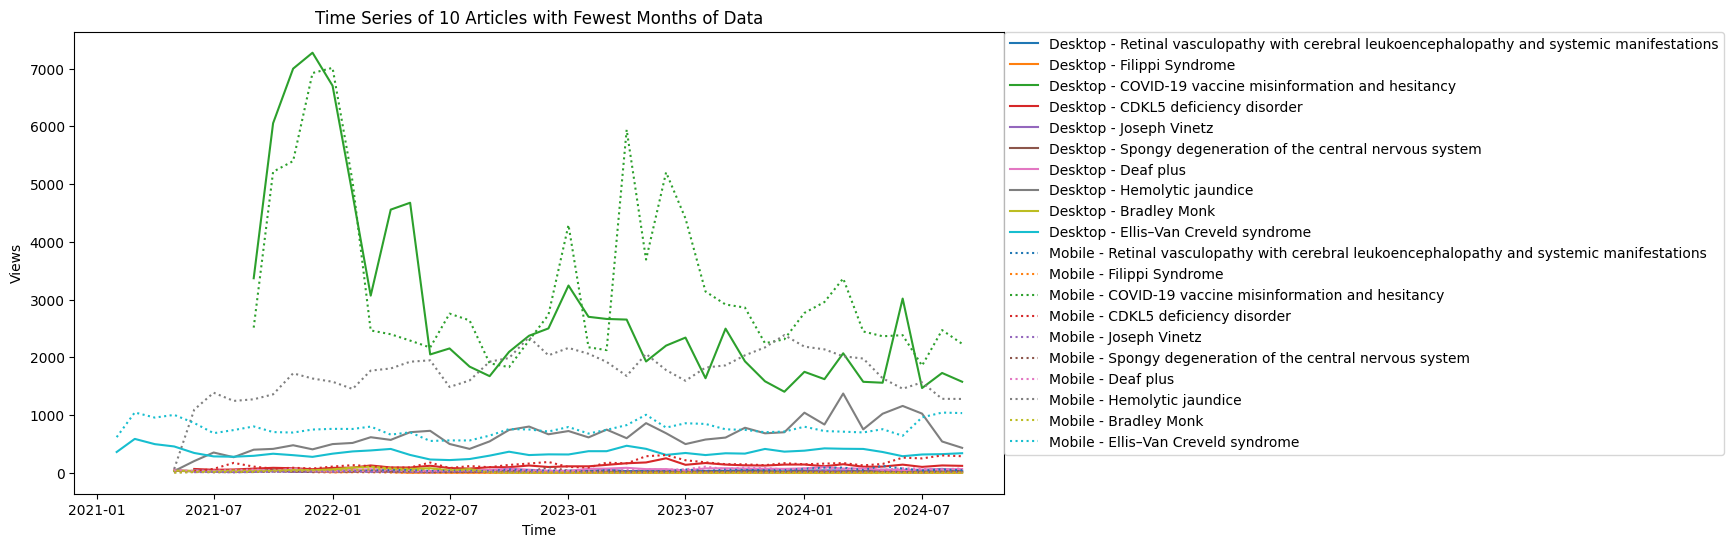

In [47]:
# Fewest months of data.

# Calculate and extract 10 articles with fewest months of data
desktop_fewest_month_data = desktop_df.count().nsmallest(10).index
mobile_fewest_month_data = mobile_df.count().nsmallest(10).index

plt.figure(figsize=(12, 6))

# Plot the data points from the desktop dataframe
for article in desktop_fewest_month_data:
    plt.plot(desktop_df.index, desktop_df[article], label=f'Desktop - {article}', linestyle='-')

# Plot the data points from the mobile dataframe
for article in mobile_fewest_month_data:
    plt.plot(mobile_df.index, mobile_df[article], label=f'Mobile - {article}', linestyle=':')

# # Format the plot
plt.title('Time Series of 10 Articles with Fewest Months of Data')
plt.xlabel('Time')
plt.ylabel('Views')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))  # Format x-axis to year-month
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.savefig('generated_plots/fewest_months_of_data.png', bbox_inches='tight')
plt.show()
plt.close()

The solid lines represent the trend in views from Jul 2015 - Sep 2024 for 10 articles with fewest months of data available viewed on desktop and dotted lines represent the trend in views from Jul 2015 - Sep 2024 for 10 articles with fewest months of data available viewed on mobile.
From the above graph we see that most articles with fewest months data have very low number of views excpet for "covid - 19 vaccine misinformation and hesitancy. Despite having few months of data available, this article has large number of views especiallu during 2021, but gradually decreases later with few spikes here and there. One possible reason for the peak in mid 2021 could be the development of new covid-19 vaccine and the speculations around getting vaccinated.